# Практическая работа №7: Редукция и сканирование на GPU

Цель работы
Изучение и реализация параллельных алгоритмов редукции и сканирования
(префиксной суммы) на GPU с использованием CUDA. Исследование
производительности этих алгоритмов и их оптимизация.

### Теоретическая часть
1. Редукция

Редукция — это операция, которая сводит множество элементов к одному
значению (например, сумма, минимум, максимум). На GPU редукция
выполняется с использованием иерархии потоков и блоков.

2. Сканирование (префиксная сумма)

Сканирование — это операция, которая вычисляет накопленный результат для
каждого элемента массива. Например, для массива [1, 2, 3, 4] префиксная
сумма будет [1, 3, 6, 10].

3. Типы памяти в CUDA


*   Глобальная память: Основная память GPU, доступная всем потокам.
*   Разделяемая память: Быстрая память, доступная только потокам
внутри одного блока.
*   Локальная память: Память, выделенная для каждого потока.

### Практическая часть

Задание 1: Реализация редукции
1. Напишите ядро CUDA для выполнения редукции (суммирования
элементов массива).
2. Используйте разделяемую память для оптимизации доступа к данным.
3. Проверьте корректность работы на тестовом массиве.

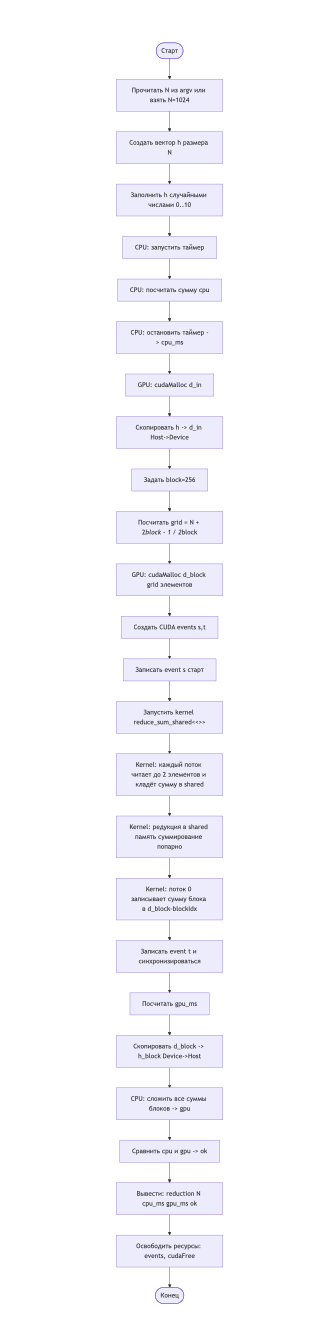

In [1]:
%%writefile prac7_task1_reduction_arg.cu
#include <cuda_runtime.h>      // CUDA функции (cudaMalloc, cudaMemcpy и т.д.)
#include <cstdio>              // printf
#include <vector>              // std::vector
#include <random>              // генерация случайных чисел
#include <chrono>              // таймер для CPU
#include <cstdlib>             // atoi

// Макрос для проверки ошибок CUDA
#define CHECK(call) do { \
  cudaError_t e = (call); \
  if (e != cudaSuccess) { \
    printf("CUDA error %s:%d: %s\n", __FILE__, __LINE__, cudaGetErrorString(e)); \
    exit(1); \
  } \
} while(0)

// -----------------------------
// CUDA kernel: редукция суммы в блоке через shared memory
// каждый блок считает свою сумму и пишет её в block_out[blockIdx.x]
// -----------------------------
__global__ void reduce_sum_shared(const int* in, unsigned long long* block_out, int n) {
    extern __shared__ unsigned long long s[];           // shared memory для частичных сумм блока

    int tid = threadIdx.x;                              // номер потока внутри блока
    int i = blockIdx.x * (blockDim.x * 2) + tid;        // глобальный индекс (читаем по 2 элемента)

    unsigned long long sum = 0;                         // локальная сумма потока

    // берём 1 элемент, если не вышли за границу
    if (i < n) sum += (unsigned long long)in[i];

    // берём второй элемент этого же блока (чтобы быстрее)
    if (i + blockDim.x < n) sum += (unsigned long long)in[i + blockDim.x];

    s[tid] = sum;                                       // сохраняем в shared memory
    __syncthreads();                                    // ждём, пока все потоки запишут данные

    // редукция в shared memory (суммируем попарно)
    for (int stride = blockDim.x / 2; stride > 0; stride >>= 1) {
        if (tid < stride) {                             // работает только половина потоков
            s[tid] += s[tid + stride];                  // складываем пару элементов
        }
        __syncthreads();                                // синхронизация после каждого шага
    }

    // поток 0 записывает итоговую сумму блока в глобальную память
    if (tid == 0) block_out[blockIdx.x] = s[0];
}

// -----------------------------
// CPU: обычная последовательная сумма
// -----------------------------
unsigned long long cpu_sum(const std::vector<int>& a) {
    unsigned long long s = 0;                           // сумма на CPU
    for (size_t i = 0; i < a.size(); i++) {             // проходим по массиву
        s += (unsigned long long)a[i];                  // добавляем элементы
    }
    return s;                                           // возвращаем сумму
}

int main(int argc, char** argv) {

    // N можно передать аргументом при запуске: ./t1 1000000
    int N = 1024;                                       // по умолчанию N=1024
    if (argc >= 2) N = std::atoi(argv[1]);              // если передали, берём N из argv

    // создаём массив на CPU
    std::vector<int> h(N);

    // заполняем случайными числами 0..10
    std::mt19937 rng(42);                               // seed для повторяемости
    std::uniform_int_distribution<int> dist(0, 10);     // диапазон значений
    for (int i = 0; i < N; i++) h[i] = dist(rng);       // заполнение

    // -----------------------------
    // CPU: считаем сумму и время
    // -----------------------------
    auto c1 = std::chrono::high_resolution_clock::now(); // старт CPU таймера
    unsigned long long cpu = cpu_sum(h);                 // сумма на CPU
    auto c2 = std::chrono::high_resolution_clock::now(); // конец таймера
    double cpu_ms = std::chrono::duration<double, std::milli>(c2 - c1).count(); // CPU время

    // -----------------------------
    // GPU: выделяем память и копируем массив
    // -----------------------------
    int* d_in = nullptr;                                // массив на GPU
    CHECK(cudaMalloc(&d_in, N * sizeof(int)));          // выделяем память
    CHECK(cudaMemcpy(d_in, h.data(), N * sizeof(int), cudaMemcpyHostToDevice)); // копируем на GPU

    // настройка сетки
    int block = 256;                                    // потоков в блоке
    int grid = (N + block * 2 - 1) / (block * 2);       // блоков (так как 2 элемента на поток)

    // массив под суммы блоков
    unsigned long long* d_block = nullptr;              // суммы каждого блока
    CHECK(cudaMalloc(&d_block, grid * sizeof(unsigned long long)));

    // события CUDA для измерения времени kernel
    cudaEvent_t s, t;
    CHECK(cudaEventCreate(&s));
    CHECK(cudaEventCreate(&t));

    // -----------------------------
    // GPU: запуск ядра и замер времени
    // -----------------------------
    CHECK(cudaEventRecord(s));                          // старт
    reduce_sum_shared<<<grid, block, block * sizeof(unsigned long long)>>>(d_in, d_block, N);
    CHECK(cudaEventRecord(t));                          // стоп
    CHECK(cudaEventSynchronize(t));                     // ждём завершения kernel

    float gpu_ms = 0.0f;                                // время GPU
    CHECK(cudaEventElapsedTime(&gpu_ms, s, t));         // считаем миллисекунды

    // -----------------------------
    // копируем суммы блоков на CPU и суммируем (финальный результат)
    // -----------------------------
    std::vector<unsigned long long> h_block(grid);      // массив сумм блоков на CPU
    CHECK(cudaMemcpy(h_block.data(), d_block, grid * sizeof(unsigned long long),
                     cudaMemcpyDeviceToHost));          // копия обратно

    unsigned long long gpu = 0;                         // итоговая сумма GPU
    for (int i = 0; i < grid; i++) gpu += h_block[i];   // складываем суммы блоков

    // проверка корректности
    int ok = (cpu == gpu) ? 1 : 0;

    // вывод: algo N cpu_ms gpu_ms ok (удобно для CSV)
    printf("reduction %d %.6f %.6f %d\n", N, cpu_ms, gpu_ms, ok);

    // -----------------------------
    // очистка памяти
    // -----------------------------
    cudaEventDestroy(s);                                // удалить events
    cudaEventDestroy(t);
    cudaFree(d_in);                                     // освободить GPU память
    cudaFree(d_block);

    return 0;                                           // конец
}


Writing prac7_task1_reduction_arg.cu


In [2]:
!nvcc -O2 -arch=sm_75 prac7_task1_reduction_arg.cu -o t1
!./t1


reduction 1024 0.000872 0.118144 1


Вывод: Для N=1024 результат редукции на CPU и GPU совпал (Correct: YES). Однако CPU работает быстрее (0.00087 ms), а GPU медленнее (0.118 ms), потому что для маленького массива накладные расходы запуска ядра и работы с памятью на GPU превышают выгоду от параллелизма.

Задание 2: Реализация префиксной суммы
1. Напишите ядро CUDA для выполнения префиксной суммы.
2. Используйте разделяемую память для оптимизации доступа к данным.
3. Проверьте корректность работы на тестовом массиве.

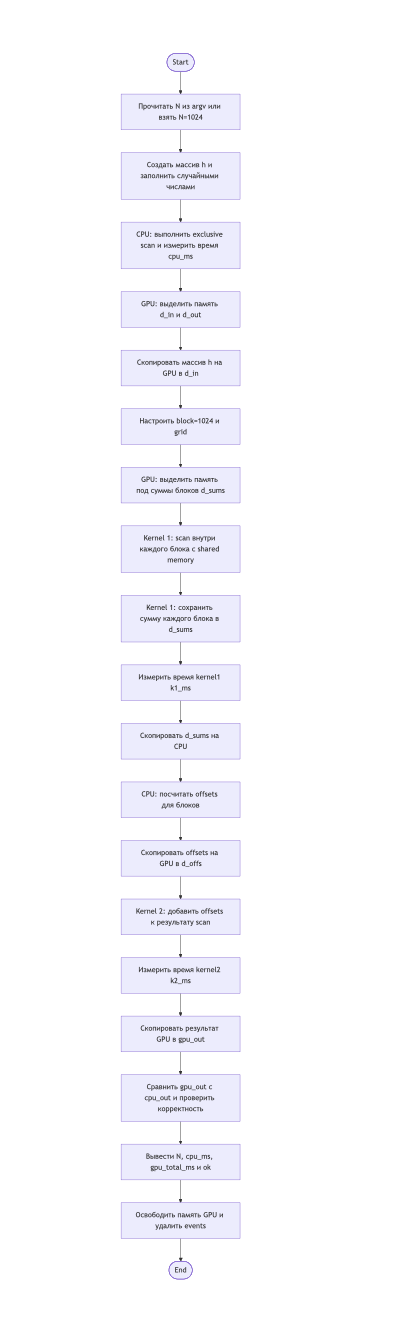

In [3]:
%%writefile prac7_task2_scan_arg.cu
#include <cuda_runtime.h>      // CUDA runtime (память, ядра, события)
#include <cstdio>              // printf
#include <vector>              // std::vector
#include <random>              // генератор случайных чисел
#include <chrono>              // таймер CPU
#include <cstdlib>             // atoi

// Макрос: если CUDA вернула ошибку — печатаем и выходим
#define CHECK(call) do { \
  cudaError_t e = (call); \
  if (e != cudaSuccess) { \
    printf("CUDA error %s:%d: %s\n", __FILE__, __LINE__, cudaGetErrorString(e)); \
    exit(1); \
  } \
} while(0)

// -----------------------------
// kernel1: exclusive scan внутри каждого блока (Blelloch scan) в shared memory
// + сохраняем сумму блока в block_sums[blockIdx.x]
// -----------------------------
__global__ void scan_block_exclusive(const int* in, int* out, int* block_sums, int n) {
    extern __shared__ int s[];                             // shared память (быстрая) для элементов блока
    int tid = threadIdx.x;                                 // индекс потока в блоке
    int gid = blockIdx.x * blockDim.x + tid;               // глобальный индекс элемента

    int x = (gid < n) ? in[gid] : 0;                       // если вышли за границы — берём 0 (padding)
    s[tid] = x;                                            // кладём элемент в shared
    __syncthreads();                                       // ждём пока все потоки загрузят данные

    // Up-sweep: строим дерево сумм (Blelloch)
    for (int offset = 1; offset < blockDim.x; offset <<= 1) {
        int idx = (tid + 1) * offset * 2 - 1;              // индекс правого узла пары
        if (idx < blockDim.x) s[idx] += s[idx - offset];   // суммируем пару в shared
        __syncthreads();                                   // синхронизация на каждом шаге
    }

    // сохраняем сумму блока и делаем exclusive: последний элемент -> 0
    if (tid == 0) {                                        // делаем это одним потоком
        block_sums[blockIdx.x] = s[blockDim.x - 1];         // сумма блока (inclusive итог)
        s[blockDim.x - 1] = 0;                              // превращаем в exclusive scan
    }
    __syncthreads();                                       // синхронизация перед down-sweep

    // Down-sweep: раскатываем префиксные суммы (Blelloch)
    for (int offset = blockDim.x >> 1; offset >= 1; offset >>= 1) {
        int idx = (tid + 1) * offset * 2 - 1;              // индекс правого узла пары
        if (idx < blockDim.x) {                            // проверка границ
            int t = s[idx - offset];                       // сохраняем левое значение
            s[idx - offset] = s[idx];                      // левое = правое
            s[idx] += t;                                   // правое += старое левое
        }
        __syncthreads();                                   // синхронизация на каждом шаге
    }

    if (gid < n) out[gid] = s[tid];                        // записываем результат для элемента (exclusive scan)
}

// -----------------------------
// kernel2: добавление оффсета блока ко всем элементам этого блока
// оффсет = сумма всех предыдущих блоков
// -----------------------------
__global__ void add_block_offsets(int* out, const int* offs, int n) {
    int gid = blockIdx.x * blockDim.x + threadIdx.x;       // глобальный индекс
    if (gid < n) out[gid] += offs[blockIdx.x];             // прибавляем смещение своего блока
}

// -----------------------------
// CPU: последовательный exclusive scan (для проверки)
// -----------------------------
void cpu_scan_exclusive(const std::vector<int>& in, std::vector<int>& out) {
    long long run = 0;                                     // накопленная сумма
    for (size_t i = 0; i < in.size(); i++) {               // идём по массиву
        out[i] = (int)run;                                 // exclusive: пишем сумму до i
        run += in[i];                                      // обновляем накопление
    }
}

int main(int argc, char** argv) {

    // N можно передать параметром: ./t2 1000000
    int N = 1024;                                          // значение по умолчанию
    if (argc >= 2) N = std::atoi(argv[1]);                 // если есть аргумент — берём его

    // создаём входной массив на CPU
    std::vector<int> h(N);
    std::mt19937 rng(7);                                   // seed для повторяемости
    std::uniform_int_distribution<int> dist(0, 5);         // маленькие числа
    for (int i = 0; i < N; i++) h[i] = dist(rng);          // заполняем

    // -----------------------------
    // CPU scan + время
    // -----------------------------
    std::vector<int> cpu_out(N);                           // результат CPU
    auto c1 = std::chrono::high_resolution_clock::now();   // старт CPU таймера
    cpu_scan_exclusive(h, cpu_out);                        // считаем scan на CPU
    auto c2 = std::chrono::high_resolution_clock::now();   // стоп таймера
    double cpu_ms = std::chrono::duration<double, std::milli>(c2 - c1).count(); // время CPU

    // -----------------------------
    // GPU: память и копирование
    // -----------------------------
    int *d_in=nullptr, *d_out=nullptr, *d_sums=nullptr, *d_offs=nullptr; // указатели на GPU
    CHECK(cudaMalloc(&d_in, N * sizeof(int)));            // выделяем память под вход
    CHECK(cudaMalloc(&d_out, N * sizeof(int)));           // выделяем память под выход
    CHECK(cudaMemcpy(d_in, h.data(), N * sizeof(int), cudaMemcpyHostToDevice)); // копируем на GPU

    // параметры запуска
    int block = 1024;                                      // блок должен быть степенью 2 для Blelloch
    int grid = (N + block - 1) / block;                    // сколько блоков нужно

    CHECK(cudaMalloc(&d_sums, grid * sizeof(int)));        // массив сумм блоков

    // события для времени GPU
    cudaEvent_t s, t;
    CHECK(cudaEventCreate(&s));
    CHECK(cudaEventCreate(&t));

    // -----------------------------
    // kernel1: scan внутри блоков + суммы блоков
    // -----------------------------
    CHECK(cudaEventRecord(s));                              // старт измерения
    scan_block_exclusive<<<grid, block, block * sizeof(int)>>>(d_in, d_out, d_sums, N);
    CHECK(cudaEventRecord(t));                              // стоп
    CHECK(cudaEventSynchronize(t));                         // ждём завершения
    float k1_ms = 0.0f;
    CHECK(cudaEventElapsedTime(&k1_ms, s, t));              // время kernel1

    // -----------------------------
    // оффсеты блоков считаем на CPU (простая версия для практики)
    // -----------------------------
    std::vector<int> sums(grid);                            // суммы блоков на CPU
    CHECK(cudaMemcpy(sums.data(), d_sums, grid * sizeof(int), cudaMemcpyDeviceToHost)); // копируем суммы

    std::vector<int> offs(grid);                            // оффсеты блоков
    long long acc = 0;                                      // накопитель
    for (int i = 0; i < grid; i++) {                        // делаем exclusive scan по суммам блоков
        offs[i] = (int)acc;                                 // оффсет для блока i
        acc += sums[i];                                     // добавляем сумму блока
    }

    CHECK(cudaMalloc(&d_offs, grid * sizeof(int)));         // память под оффсеты на GPU
    CHECK(cudaMemcpy(d_offs, offs.data(), grid * sizeof(int), cudaMemcpyHostToDevice)); // копируем оффсеты

    // -----------------------------
    // kernel2: прибавляем оффсеты ко всем элементам блока
    // -----------------------------
    CHECK(cudaEventRecord(s));                              // старт
    add_block_offsets<<<grid, block>>>(d_out, d_offs, N);    // добавляем оффсеты
    CHECK(cudaEventRecord(t));                              // стоп
    CHECK(cudaEventSynchronize(t));                         // ждём
    float k2_ms = 0.0f;
    CHECK(cudaEventElapsedTime(&k2_ms, s, t));              // время kernel2

    // -----------------------------
    // копируем результат и проверяем корректность
    // -----------------------------
    std::vector<int> gpu_out(N);                            // результат GPU на CPU
    CHECK(cudaMemcpy(gpu_out.data(), d_out, N * sizeof(int), cudaMemcpyDeviceToHost)); // копируем назад

    int bad = -1;                                           // индекс ошибки
    for (int i = 0; i < N; i++) {                           // сравниваем с CPU
        if (gpu_out[i] != cpu_out[i]) { bad = i; break; }
    }
    int ok = (bad == -1) ? 1 : 0;                           // 1 если корректно

    // вывод в формате: algo N cpu_ms gpu_ms ok
    float gpu_total_ms = k1_ms + k2_ms;                     // суммарное время двух ядер
    printf("scan %d %.6f %.6f %d\n", N, cpu_ms, gpu_total_ms, ok);

    // -----------------------------
    // очистка ресурсов
    // -----------------------------
    cudaEventDestroy(s);
    cudaEventDestroy(t);
    cudaFree(d_in);
    cudaFree(d_out);
    cudaFree(d_sums);
    cudaFree(d_offs);
    return 0;
}


Writing prac7_task2_scan_arg.cu


In [4]:
!nvcc -O2 -arch=sm_75 prac7_task2_scan_arg.cu -o t2
!./t2

scan 1024 0.000751 0.135808 1


Вывод: Для N=1024 результаты сканирования на CPU и GPU совпали (Correct: YES). Но CPU быстрее (0.000751 ms), а GPU медленнее (0.13581 ms), так как на маленьких массивах накладные расходы запуска CUDA и синхронизаций превышают пользу от параллельной обработки.

Задание 3: Анализ производительности
1. Замерьте время выполнения редукции и сканирования для массивов
разного размера.
2. Сравните производительность с CPU-реализацией.
3. Проведите оптимизацию кода, используя различные типы памяти
CUDA.

Для анализа был использован пайтон, чтобы сделать графики в колабе.

In [5]:
import subprocess
import pandas as pd

sizes = [1024, 1_000_000, 10_000_000]

def run_prog(prog, n):
    # запускаем ./t1 N или ./t2 N и парсим 1 строку: algo N cpu_ms gpu_ms correct
    out = subprocess.check_output([prog, str(n)], text=True).strip()
    parts = out.split()
    # пример: reduction 1024 0.000830 0.125248 1
    algo = parts[0]
    N = int(parts[1])
    cpu_ms = float(parts[2])
    gpu_ms = float(parts[3])
    correct = int(parts[4])
    speedup = cpu_ms / gpu_ms if gpu_ms > 0 else None
    return {"algo": algo, "N": N, "cpu_ms": cpu_ms, "gpu_ms": gpu_ms, "correct": correct, "speedup": speedup}

rows = []
for n in sizes:
    rows.append(run_prog("./t1", n))  # reduction
for n in sizes:
    rows.append(run_prog("./t2", n))  # scan

df = pd.DataFrame(rows).sort_values(["algo","N"]).reset_index(drop=True)
df.to_csv("prac7_task3_perf.csv", index=False)

df


,algo,N,cpu_ms,gpu_ms,correct,speedup
0,reduction,1024,0.000599,0.090336,1,0.006631
1,reduction,1000000,0.540719,0.152416,1,3.547652
2,reduction,10000000,5.619247,0.616032,1,9.121680
3,scan,1024,0.000745,0.144096,1,0.005170
4,scan,1000000,0.556359,0.577760,1,0.962959
5,scan,10000000,7.522310,4.534176,1,1.659025


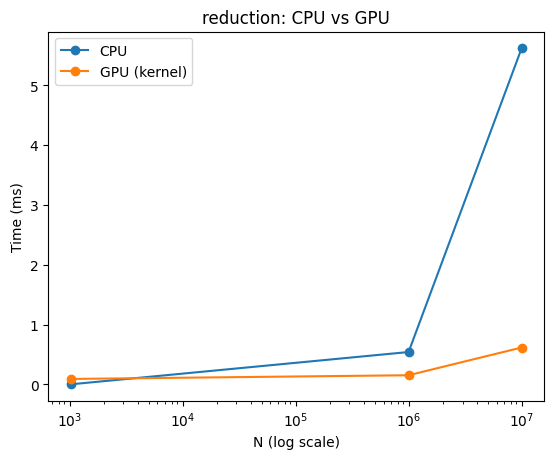

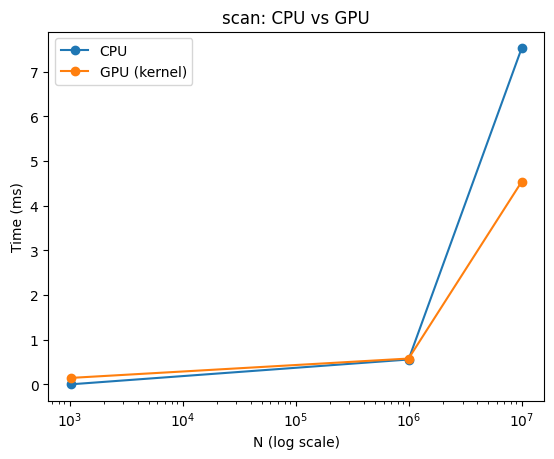

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("prac7_task3_perf.csv")

for algo in ["reduction", "scan"]:
    d = df[df["algo"] == algo].copy()
    plt.figure()
    plt.plot(d["N"], d["cpu_ms"], marker="o", label="CPU")
    plt.plot(d["N"], d["gpu_ms"], marker="o", label="GPU (kernel)")
    plt.xscale("log")
    plt.xlabel("N (log scale)")
    plt.ylabel("Time (ms)")
    plt.title(f"{algo}: CPU vs GPU")
    plt.legend()
    plt.show()


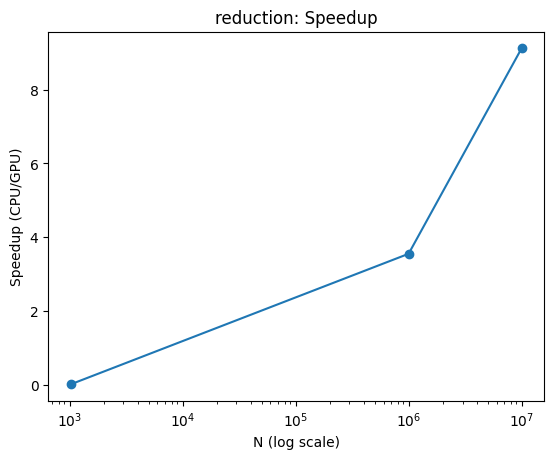

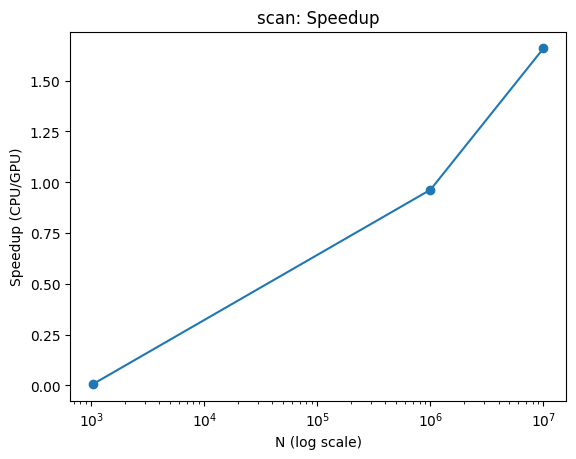

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("prac7_task3_perf.csv")

for algo in ["reduction", "scan"]:
    d = df[df["algo"] == algo].copy()
    plt.figure()
    plt.plot(d["N"], d["speedup"], marker="o")
    plt.xscale("log")
    plt.xlabel("N (log scale)")
    plt.ylabel("Speedup (CPU/GPU)")
    plt.title(f"{algo}: Speedup")
    plt.show()


Вывод: Эксперименты показали, что при малых размерах массива CPU работает быстрее, а GPU проигрывает из-за накладных расходов. При увеличении размера массива GPU становится эффективнее: для редукции наблюдается ускорение до примерно 9.21×, для сканирования — до примерно 1.65. Использование shared memory улучшает производительность, так как снижает обращения к глобальной памяти и ускоряет вычисления внутри блока.

# Контрольные вопросы
1. В чём разница между редукцией и сканированием?

Редукция сводит массив к одному значению, например сумме. Сканирование вычисляет префиксные суммы и возвращает массив результатов.

2. Какие типы памяти CUDA используются для оптимизации редукции и сканирования?

Основные типы памяти — глобальная и разделяемая (shared). Для ускорения редукции и сканирования часто используют shared memory, потому что она быстрее, чем глобальная.

3. Как можно оптимизировать префиксную сумму на GPU?

Нужно выполнять scan внутри блока в shared memory и уменьшать количество обращений к глобальной памяти. Также важно правильно выбирать размер блока и эффективно добавлять оффсеты блоков.

4. Приведите пример задачи, где применяется сканирование.

Сканирование применяется для вычисления накопленных сумм, например в задачах подсчёта префиксных сумм массива. Ещё пример — уплотнение массива (stream compaction), когда нужно построить индексы для элементов, прошедших фильтр.